<a href="https://colab.research.google.com/github/bjatkin/Pepto-GAN/blob/master/Pepto_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports for everything here

In [0]:
import argparse
import os
import numpy as np
import math
import random
import csv
from tqdm import tqdm

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# Utility Functions

Genral functions that have broad use across differnt sections of the code base. Should be functions rather than classes.

In [0]:
def one_hot(peptide):
  encodings = []
  for aa in peptide:
    encoding = torch.zeros(len(gan_opt.amino_acids))
    index = gan_opt.amino_acids.index(aa)
    encoding[index] = 1.0
    encodings.append(encoding)
  return torch.stack(encodings)

def one_hot_s(peptides):
  all_encodings = []
  for peptied in peptides:
    all_encodings.append(one_hot(peptied))
  return torch.stack(all_encodings)

def score_peptide(peptide):
  return tox_predictor(one_hot(peptide).unsqueeze(0).cuda()).item()

def decode_peptide(peptide):
  pep = ""
  for p in peptide:
    i = p.argmax()
    pep = pep + gan_opt.amino_acids[i]
  
  return pep

def decode_peptide_s(peptides):
  peps = []
  for peptide in peptides:
    peps.append(decode_peptide(peptide))
  
  return np.asarray(peps)

def generate_random_peptide():
  encodings = []
  l = len(gan_opt.amino_acids)
  for _ in range(l):
    encoding = torch.zeros(gan_opt.peptide_length)
    index = random.randrange(0, gan_opt.peptide_length)
    encoding[index] = 1.0
    encodings.append(encoding)
  return torch.stack(encodings)

def generate_random_peptide_s(count):
  all_encodings = []
  for _ in range(count):
    all_encodings.append(generate_random_peptide())
  return torch.stack(all_encodings)

def save_model(model, file_name):
  torch.save(model.state_dict(), file_name)

def load_model(model, file_name):
  model.load_state_dict(torch.load(file_name))

# Network Opts

This section should contain global options that configure each network

In [0]:
# Toxic Classifier Options

class tox_opt():
  n_epochs=10
  batch_size=64
  lr=0.0005
  validate_every=500
  load_network = True
  load_model_file="tox_classifier.pt"
  save_model_file="tox_classifier.pt"


# GAN Options

class gan_opt():
  n_epochs=120
  batch_size=64
  lr=0.0002
  b1=0.5
  b2=0.999
  latent_dim=100
  peptide_length=8
  amino_acids="CDFGHILNRSVY"
  d_update_every=10
  label_smoothing=True
  load_discriminator=False
  load_disc_file="tox_discriminator.pt"
  save_disc_file="tox_discriminator.pt"
  load_generator=False
  load_gen_file="tox_generator.pt"
  save_gen_file="tox_generator.pt"
  train_gan=True

# Washerstein GAN Options

class was_opt():
  n_epochs=120
  batch_size=64
  lr=0.001
  b1=0.5
  b2=0.999
  latent_dim=100
  clip_value=0.01
  n_critic=5
  label_smoothing=False
  load_discriminator=False
  load_disc_file="was_tox_discriminator.pt"
  save_disc_file="was_tox_discriminator.pt"
  load_generator=False
  load_gen_file="was_tox_generator.pt"
  save_gen_file="was_tox_generator.pt"
  train_gan=True


# Peptide Dataloader

In [0]:
# --------------------
# Peptides Dataloader
# --------------------
class ToxicPeptideDataset(Dataset):
  def __init__(self, file_name, labels_file_name="", train=True, soft=False):
    if soft:
      self.peptides = self.one_soft(np.load(file_name))
    else:
      self.peptides = self.one_hot(np.load(file_name))

    self.use_labels = False
    if labels_file_name != "":
      self.use_labels = True
      # These come in as strings and need to be floats
      self.labels = [float(l) for l in np.load(labels_file_name)]

      # Test train split
      split = len(self.labels) // 10
      if train:
        self.peptides = self.peptides[split:]
        self.labels = self.labels[split:]
      else:
        self.peptides = self.peptides[:split]
        self.labels = self.labels[:split]

  def one_hot(self, peptides):
    all_encodings = []
    for peptide in peptides:
      encodings = []
      for aa in peptide:
        encoding = torch.zeros(len(gan_opt.amino_acids))
        index = gan_opt.amino_acids.index(aa)
        encoding[index] = 1.0
        encodings.append(encoding)
      all_encodings.append(torch.stack(encodings))

    return all_encodings
  
  def one_soft(self, peptides, alpha=0.3):
    all_encodings = []
    for peptide in peptides:
      encodings = []
      for aa in peptide:
        cs = len(gan_opt.amino_acids)
        encoding = torch.ones(cs) * (alpha/(cs-1))
        index = gan_opt.amino_acids.index(aa)
        encoding[index] = 1 - alpha
        encodings.append(encoding)
      all_encodings.append(torch.stack(encodings))

    return all_encodings

    
  def __getitem__(self, index):
    if self.use_labels:
      return self.peptides[index], self.labels[index]
    return self.peptides[index]
    
  def __len__(self):
    return len(self.peptides)

# Toxic Peptide Classifier

the goal of this model is to predict the toxicity score of a peptide. This can then be used to access the success of the GAN

In [0]:
# -------------------------
# Toxic Peptide classifier
# -------------------------

class ToxicityPredictor(nn.Module):
  def __init__(self):
    super(ToxicityPredictor, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(int(len(gan_opt.amino_acids) * gan_opt.peptide_length), 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
    )

  def forward(self, pep):
    pep_flat = pep.view(pep.size(0), -1)
    tox = self.model(pep_flat)

    return tox

# Loss function
toxicity_loss = nn.L1Loss()

# Initialize Predictor
tox_predictor = ToxicityPredictor()

if cuda:
  tox_predictor.cuda()
  toxicity_loss.cuda()

# Optimizer
optimizer_tox = torch.optim.Adam(tox_predictor.parameters(), lr=tox_opt.lr)


# Data Loaders
if not tox_opt.load_network:
  tox_data_train = ToxicPeptideDataset("allPeptideSequences.npy", "allPeptideScores.npy", train=True)
  tox_dataloader_train = torch.utils.data.DataLoader(tox_data_train, batch_size=tox_opt.batch_size, shuffle=True)

  tox_data_test = ToxicPeptideDataset("allPeptideSequences.npy", "allPeptideScores.npy", train=False)
  tox_dataloader_test = torch.utils.data.DataLoader(tox_data_test, batch_size=tox_opt.batch_size, shuffle=True)

In [0]:
def accuracy(y_hat, y_truth):
  diff = torch.abs(y_hat-y_truth)
  count = y_hat.size()[0]
  return (count - torch.sum(diff))/count

In [104]:
# ------------------------------
#  Toxicicty Predictor Training
# ------------------------------

losses = []
v_losses = []
acc = []
def tox_train():
  loop = tqdm(total=len(tox_dataloader_train) * tox_opt.n_epochs, position=0)
  for epoch in range(tox_opt.n_epochs):

      for i, (peps, toxs) in enumerate(tox_dataloader_train):
          peps = Variable(peps.type(Tensor))
          toxs = Variable(toxs.type(Tensor))
          optimizer_tox.zero_grad()

          y_hat = tox_predictor(peps)

          # loss = toxicity_loss(y_hat.squeeze(), toxs)
          # pdb.set_trace()
          loss = torch.sum(torch.abs(y_hat.squeeze()-toxs))
          loss.backward()
          losses.append(loss.item())
          optimizer_tox.step()
          last_acc = 0
          if i % tox_opt.validate_every:
            a = []
            for v_peps, v_toxs in tox_dataloader_test:
              v_peps = Variable(v_peps.type(Tensor))
              v_toxs = Variable(v_toxs.type(Tensor))
              v_y_hat = tox_predictor(v_peps)
              a.append(accuracy(v_y_hat.squeeze(), v_toxs).item())
            last_acc = np.mean(a)
            acc.append((len(losses), last_acc))

          loop.set_description("Epoch {}, Batch {}, Toxic_Loss {:.4f}, Accuracy {:.4f}".format(epoch, i, loss.item(), last_acc))
          loop.update()

# No need to retrain if we can just load the network from a file
if not tox_opt.load_network:
  tox_train()
  save_model(tox_predictor, tox_opt.save_model_file)

  # Plot accuracy and loss
  plt.plot(losses, label='losses')
  plt.title('Toxicicity Predictor Losses')
  plt.legend()
  plt.show()

  a, b = zip(*acc)
  plt.plot(a, b, label='accuracy')
  plt.title('Tocicity Accuracy')
  plt.legend()
  plt.show()

if tox_opt.load_network:
  load_model(tox_predictor, tox_opt.load_model_file)
  print("Network Successfully Loaded!")


Network Successfully Loaded!


# Pepto GAN

this section contains the code to run a simple gan forward on the peptide dataset. Ultimately it should produce toxic peptides as its output

*be sure to re-run all the cells in this section each time the GAN is run otherwise the Generator and the Discriminator will not be re-initalized*

## Experiment 1
  * lr=0.0002
  * b1=0.5
  * b2=0.999
  * latent_dim=100
  * d_update_every=100
  * label_smoothing=False

**Results: epoch 120/120 d loss 0.0014, g loss 6.6079, unique 1.5000%, mean: -1.1950, std: 0.3212**

## Experiment 2
  * lr=0.0002
  * b1=0.5
  * b2=0.999
  * latent_dim=100
  * d_update_every=10
  * label_smoothing=False

the final epoch was not chosen as the performance fell drastically after epoch 107 and did not have time to recover. It's also interesting to note that d loss dropped to 0 after only 50 epochs but the network seemed to still be able to train.

**Results: epoch 107/120 d loss 0.0000, g loss 13.2041, unique 1.7000%, mean: -1.1205, std: 0.1167**

## Experiment 3
  * lr=0.0002
  * b1=0.5
  * b2=0.999
  * latent_dim=100
  * d_update_every=100
  * label_smoothing=True

the training seemed to be a little bit smoother here.

**Results: epoch 120/120 d loss 0.0069, g loss 5.0971, unique: 0.9000%, mean: -1.0141, std: 0.2059**

## Experiment 4
  * lr=0.0002
  * b1=0.5
  * b2=0.999
  * latent_dim=100
  * d_update_every=10
  * label_smoothing=True

epoch 114 was chosen because pefromance fell drastically after wards and didnt have time to recover. Here d loss dropped to 0 at around epoch 70. Training seemed smooth but ultimately unsuccessful.

**Results: epoch 114/120 d loss 0.0000, g loss 13.2736, unique: 2.2000%, mean: -0.7249, std: 0.2899**

In [0]:
# ---------------------------------------
# Define the Generator and Discriminator
# ---------------------------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(gan_opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(gan_opt.peptide_length * len(gan_opt.amino_acids))),
            nn.Tanh()
        )

    def forward(self, z):
        pep = self.model(z)
        pep = pep.view(pep.size()[0], gan_opt.peptide_length, len(gan_opt.amino_acids))
        pep = F.softmax(pep, dim=2)
        return pep


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(len(gan_opt.amino_acids) * gan_opt.peptide_length), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, pep):
        pep_flat = pep.view(pep.size(0), -1)
        validity = self.model(pep_flat)

        return validity

# Dataset
gan_data = ToxicPeptideDataset("newMostToxicNCSequences.npy", soft=gan_opt.label_smoothing)
gan_dataloader = torch.utils.data.DataLoader(gan_data, batch_size=gan_opt.batch_size, shuffle=True)

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=gan_opt.lr, betas=(gan_opt.b1, gan_opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=gan_opt.lr, betas=(gan_opt.b1, gan_opt.b2))

In [0]:
# --------------
#  GAN Training
# --------------

def gan_train():
  for epoch in range(gan_opt.n_epochs):

      for i, peps in enumerate(gan_dataloader):

          # Adversarial ground truths
          valid = Variable(Tensor(peps.size(0), 1).fill_(1.0), requires_grad=False)
          fake = Variable(Tensor(peps.size(0), 1).fill_(0.0), requires_grad=False)

          # Configure input
          real_peps = Variable(peps.type(Tensor))

          # -----------------
          #  Train Generator
          # -----------------

          optimizer_G.zero_grad()

          # Sample noise as generator input
          z = Variable(Tensor(np.random.normal(0, 1, (peps.shape[0], gan_opt.latent_dim))))

          # Sample high constrast noise as generator input (Tweak #2)
          # z = Variable(Tensor(np.random.randint(0, 2, (peps.shape[0], gan_opt.latent_dim))))

          # Generate a batch of images
          gen_peps = generator(z)

          # Loss measures generator's ability to fool the discriminator
          g_loss = adversarial_loss(discriminator(gen_peps), valid)

          g_loss.backward()
          optimizer_G.step()

          # ---------------------
          #  Train Discriminator - every d_update_every steps
          # ---------------------

          batches_done = epoch * len(gan_dataloader) + i
          if batches_done % gan_opt.d_update_every == 0:
            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(real_peps), valid)
            fake_loss = adversarial_loss(discriminator(gen_peps.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

      unique, mean, std = evaluate_gan(generator)
      print("epoch {}/{} d loss {:.4f}, g loss {:.4f}, unique: {:.4f}%, mean: {:.4f}, std: {:.4f}".format(epoch+1, gan_opt.n_epochs, d_loss.item(), g_loss.item(), unique, mean, std))

if gan_opt.load_discriminator:
  load_model(discriminator, gan_opt.load_disc_file)

if gan_opt.load_generator:
  load_model(generator, gan_opt.load_gen_file)

if gan_opt.train_gan:
  gan_train()
  save_model(discriminator, gan_opt.save_disc_file)
  save_model(generator, gan_opt.save_gen_file)

# Pepto GAN - Washerstein GAN

This section contains the code to run a washerstein gan forward on the peptide dataset. Ultimately it should produce toxic peptides as its output.

*be sure to re-run all the cells in this section each time the WGAN is run otherwise the Generator and the Discriminator will not be re-initalized*

Note: Experiments 1- 4 use the newMostToxicNCSeuences.npy dataset

## Experiment 1
 * n_epochs=120
 * batch_size=64
 * lr=0.001
 * b1=0.5
 * b2=0.999
 * latent_dim=100
 * clip_value=0.01
 * n_critic=5
 * label_smoothing=False

It looks like the washerstein gan fixes the modal colapse. Also it looks like the WGAN reduces its loss specifically by generating a variety of peptides rather than highly toxic peptides.

**Results: epoch 120/120 d loss -0.1048, g loss 0.0275, unique 99.3000%, mean: -0.7451, std: 0.2461**

## Experiment 2
 * n_epochs=120
 * batch_size=64
 * lr=0.001
 * b1=0.5
 * b2=0.999
 * latent_dim=100
 * clip_value=0.01
 * n_critic=5
 * label_smoothing=True

Label Smoothing does not help the WGAN at all.

**Results: epoch 120/120 d loss 0.0093, g loss 0.0040, unique 88.4000%, mean: -0.6492, std: 0.2866**

## Experiment 3
 * n_epochs=120
 * batch_size=64
 * lr=0.001
 * b1=0.5
 * b2=0.999
 * latent_dim=100
 * clip_value=0.01
 * n_critic=20
 * label_smoothing=False

Slowing the generator learning rate seems to help toxicity scores but makes the generator produce slightly less varried results.

**Results: epoch 120/120 d loss -0.0817, g loss 0.0534, unique 89.1000%, mean: -0.7930, std: 0.2221**

## Experiment 4
 * n_epochs=120
 * batch_size=64
 * lr=0.001
 * b1=0.5
 * b2=0.999
 * latent_dim=100
 * clip_value=0.01
 * n_critic=100
 * label_smoothing=False

This seems like this has gone too far

**Results: epoch 120/120 d loss -0.0813, g loss 0.0418, unique 72.0000%, mean: -0.7263, std: 0.2341**

## Experiment 5
  * n_epochs=120
  * batch_size=64
  * lr=0.001
  * b1=0.5
  * b2=0.999
  * latent_dim=100
  * clip_value=0.01
  * n_critic=5
  * label_smoothing=False

I ran this experiment by generating a top 40k, 30k, 20k, 10k, 5k, 2k, 1k toxic non-canonical peptides. I then trained the WGAN first on the 40k dataset, followed by the 30k dataset and so on until I finally trained it on the 1k dataset. There was very little different between training it on the 30 and 40 k datasets. However by the time it finished training on this dataset it's unique value was 99% or above. this uniqeness remained untill I started training it on the 2k and 1k dataset when uniqueness dropped quickly even as the mean toxicity improved. Ultimately the greatest shifts in toxicity came from training on the 2k and 1k datasets. We should probably investigate the mean and std of each of these datasets as my assumption is that the WGAN will match the statistics of the underlying datasets quite well. Whether this will pose a practical limit on Pepto GAN or not remains to be seen.

**Results: epoch 120/120 d loss -0.0847, g loss 0.0231, unique 49.0000%, mean: -0.9063, std: 0.1430**

In [0]:
# ---------------------------------------------------
# Define the Washerstein Generator and Descriminator
# ---------------------------------------------------
class WGenerator(nn.Module):
    def __init__(self):
        super(WGenerator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(was_opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(gan_opt.peptide_length * len(gan_opt.amino_acids))),
            nn.Tanh()
        )

    def forward(self, z):
        pep = self.model(z)
        pep = pep.view(pep.size()[0], gan_opt.peptide_length, len(gan_opt.amino_acids))
        pep = F.softmax(pep, dim=2)
        return pep

class WDiscriminator(nn.Module):
    def __init__(self):
        super(WDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(len(gan_opt.amino_acids) * gan_opt.peptide_length), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, pep):
        pep_flat = pep.view(pep.size(0), -1)
        validity = self.model(pep_flat)

        return validity

# Initialize generator and discriminator
w_generator = WGenerator()
w_discriminator = WDiscriminator()

if cuda:
    w_generator.cuda()
    w_discriminator.cuda()

# Configure data loader
w_gan_data = ToxicPeptideDataset("40K_NC_Toxic_Sequences.npy", soft=was_opt.label_smoothing)
w_gan_dataloader = torch.utils.data.DataLoader(w_gan_data, batch_size=was_opt.batch_size, shuffle=True)

# Optimizers
w_optimizer_G = torch.optim.RMSprop(w_generator.parameters(), lr=was_opt.lr)
w_optimizer_D = torch.optim.RMSprop(w_discriminator.parameters(), lr=was_opt.lr)

In [170]:
# --------------------------
#  Washerstein GAN Training
# --------------------------

# Configure data loader
print("Loading New Dataset...")
w_gan_data = ToxicPeptideDataset("1K_NC_Toxic_Sequences.npy", soft=was_opt.label_smoothing)
w_gan_dataloader = torch.utils.data.DataLoader(w_gan_data, batch_size=was_opt.batch_size, shuffle=True)

def was_gan_train():
    for epoch in range(was_opt.n_epochs):

        for i, peps in enumerate(w_gan_dataloader):

            # Configure input
            real_peps = Variable(peps.type(Tensor))

            # ---------------------
            #  Train Discriminator
            # ---------------------

            w_optimizer_D.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (peps.shape[0], was_opt.latent_dim))))

            # Generate a batch of peptides
            gen_peps = w_generator(z).detach()
            # Adversarial loss
            d_loss = -torch.mean(w_discriminator(real_peps)) + torch.mean(w_discriminator(gen_peps))

            d_loss.backward()
            w_optimizer_D.step()

            # Clip weights of discriminator
            for p in w_discriminator.parameters():
                p.data.clamp_(-was_opt.clip_value, was_opt.clip_value)

            # Train the generator every n_critic iterations
            if i % was_opt.n_critic == 0:

                # -----------------
                #  Train Generator
                # -----------------

                w_optimizer_G.zero_grad()

                # Generate a batch of images
                gen_peps = w_generator(z)
                # Adversarial loss
                g_loss = -torch.mean(w_discriminator(gen_peps))

                g_loss.backward()
                w_optimizer_G.step()

        unique, mean, std = evaluate_gan(w_generator)
        print("epoch {}/{} d loss {:.4f}, g loss {:.4f}, unique {:.4f}%, mean: {:.4f}, std: {:.4f}".format(epoch+1, was_opt.n_epochs, d_loss.item(), g_loss.item(), unique, mean, std))

if was_opt.load_discriminator:
  load_model(w_discriminator, was_opt.load_disc_file)

if was_opt.load_generator:
  load_model(w_generator, was_opt.load_gen_file)

if was_opt.train_gan:
  was_gan_train()
  save_model(w_discriminator, was_opt.save_disc_file)
  save_model(w_generator, was_opt.save_gen_file)

Loading New Dataset...
epoch 1/120 d loss -0.1115, g loss 0.0153, unique 70.5000%, mean: -0.7874, std: 0.1903
epoch 2/120 d loss -0.0964, g loss 0.0211, unique 68.9000%, mean: -0.8145, std: 0.1880
epoch 3/120 d loss -0.1200, g loss 0.0269, unique 68.2000%, mean: -0.8380, std: 0.1656
epoch 4/120 d loss -0.1029, g loss 0.0277, unique 64.6000%, mean: -0.8432, std: 0.1748
epoch 5/120 d loss -0.1017, g loss 0.0244, unique 64.5000%, mean: -0.8617, std: 0.1674
epoch 6/120 d loss -0.1134, g loss 0.0273, unique 61.4000%, mean: -0.8608, std: 0.1605
epoch 7/120 d loss -0.1248, g loss 0.0268, unique 59.1000%, mean: -0.8790, std: 0.1510
epoch 8/120 d loss -0.0895, g loss 0.0369, unique 59.3000%, mean: -0.8664, std: 0.1529
epoch 9/120 d loss -0.0994, g loss 0.0188, unique 56.6000%, mean: -0.8766, std: 0.1494
epoch 10/120 d loss -0.1215, g loss 0.0172, unique 56.1000%, mean: -0.8843, std: 0.1442
epoch 11/120 d loss -0.1142, g loss 0.0308, unique 56.3000%, mean: -0.8806, std: 0.1449
epoch 12/120 d los

# GAN evalutation

Code to evaluate gan performance on several heuristics to see which setup provides the best results.

Unique Peptides Generated: 2914
Mean Score: -0.895486
Standard Deviation: 0.166711
Distance Between Means: 0.700684


(9.713333333333333, -0.8954861760139465, 0.1667114794254303)

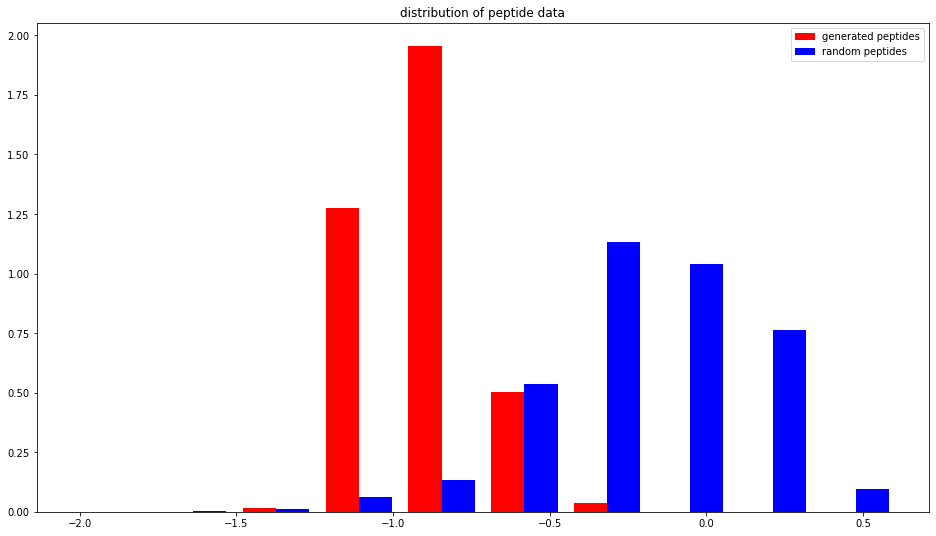

In [178]:
# ---------------
# GAN evaluation
# ---------------

def evaluate_gan(test_model, count=1000, draw_histogram=False):
  z = Variable(Tensor(np.random.normal(0, 1, (count, gan_opt.latent_dim))))

  gen = test_model(z)
  peptides = decode_peptide_s(gen)
  peptides = np.unique(peptides)
  peptides = one_hot_s(peptides)

  gen_scores = tox_predictor(peptides.cuda())

  if draw_histogram:
    print("Unique Peptides Generated: {}".format(peptides.size(0)))
    print("Mean Score: {:.6f}".format(gen_scores.mean()))
    print("Standard Deviation: {:.6f}".format(gen_scores.std()))
    # generate comparison data
    data = generate_random_peptide_s(count)
    data_scores = tox_predictor(data.cuda())
    print("Distance Between Means: {:.6f}".format(data_scores.mean().item() - gen_scores.mean().item()))

    colors = ['red', 'blue']
    labels = ['generated peptides', 'random peptides']
    plt.figure(figsize=(16,9))
    plt.hist(
        [gen_scores.detach().cpu().numpy(), data_scores.detach().cpu().numpy()], 
        bins=10, density=True, histtype='bar', color=colors, label=labels)
    plt.legend(prop={'size': 10})
    plt.title('distribution of peptide data')

  uniqueness = (peptides.size(0)/count)*100
  return uniqueness, gen_scores.mean().item(), gen_scores.std().item()

evaluate_gan(w_generator, count=30000, draw_histogram=True)

In [195]:
# ---------------
# Top N peptides
# ---------------

#generate and display the top N toxic peptides
def top_n_peptides(generator, count=20):
    z = Variable(Tensor(np.random.normal(0, 1, (count*100, gan_opt.latent_dim))))

    gen = generator(z)
    peptides = decode_peptide_s(gen)
    peptides = np.unique(peptides)
    peptides = one_hot_s(peptides)

    gen_scores = tox_predictor(peptides.cuda())
    score = np.array(gen_scores.squeeze().tolist())
    peptide_data = [(pep, score[i]) for i, pep in enumerate(decode_peptide_s(peptides))]
    peptide_data.sort(key=lambda tup: tup[1]) 
    return peptide_data[:count]

top_n_peptides(w_generator)

[('YYYLRIYL', -1.3079304695129395),
 ('IYYLYIRY', -1.2074322700500488),
 ('LYYYYIYL', -1.206214427947998),
 ('IYYLYIRL', -1.201981544494629),
 ('FYLYYYLY', -1.1993763446807861),
 ('LYIYIYRY', -1.1973598003387451),
 ('YLYYYIRY', -1.1969962120056152),
 ('YYIIFYRY', -1.1729531288146973),
 ('FYLYLYLL', -1.1697323322296143),
 ('IYYYYIRY', -1.1666827201843262),
 ('RYYLVIYL', -1.1643898487091064),
 ('FYLYYIRY', -1.1631367206573486),
 ('YYYLRYYL', -1.1611418724060059),
 ('LHIIFYYY', -1.1596765518188477),
 ('YYYIYYRL', -1.1584758758544922),
 ('LYILYYRY', -1.1553714275360107),
 ('YYYLYYRL', -1.1538212299346924),
 ('IYIYYIRY', -1.1495006084442139),
 ('YYYYYYLL', -1.1484143733978271),
 ('FYLYLILL', -1.1483674049377441)]

# Data Genreation

code that takes the original dataset and modifies it to be better/ more usable.

In [9]:
# -------------------
# Generate Base Data
# -------------------

all_sequences = []
all_scores = []
with open('all_data_filtered.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=",")
    line_count = 0
    for row in csv_reader:
      line_count += 1
      all_sequences.append(row[0])
      all_scores.append(row[1])
    
    print(f'\nProcessed {line_count} lines.\n')
  
#This is the base dataset that everything is based on
np.save("allPeptideSequences", all_sequences)
np.save("allPeptideScores", all_scores)

 64%|██████▍   | 67729/105416 [00:00<00:00, 677279.34it/s]


Processed 105416 lines.



In [171]:
# -----------------------------------
# Top-N Non Canonical Toxic Peptides
# -----------------------------------
import pdb
def toxic_non_cannon(count):
    peptides = []
    non_cannon_peps = []

    # Read in all the peptides and scores
    with open('all_data_filtered.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        for row in csv_reader:
            peptides.append((row[0], row[1]))

    for p in peptides:
        sequence = p[0]

        hydrophobicity = 0
        cysteines = 0
        for aa in sequence:
            if aa in ["F","I","V","L","W"]:
                hydrophobicity = hydrophobicity + 1
            if aa == "C":
                cysteines = cysteines + 1

        if hydrophobicity < 4 and cysteines < 3:
            non_cannon_peps.append((sequence, float(p[1])))

    non_cannon_peps.sort(key=lambda tup: tup[1]) 
    ret = np.array(non_cannon_peps[:count])
    return ret[:,0], ret[:,1]
    
dataset_size = [40, 30, 20, 10, 5, 2, 1] #Size is in thousands
for s in dataset_size:
  sk = s * 1000
  print("Generating the top {}K toxic NC peptide...".format(s))
  peptides, scores = toxic_non_cannon(sk)
  print("Saving Data...".format(s))
  np.save("{}K_NC_Toxic_Sequences".format(s), peptides)
  np.save("{}K_NC_Toxic_Scores".format(s), scores)

Generating the top 40K toxic NC peptide...
Saving Data...
Generating the top 30K toxic NC peptide...
Saving Data...
Generating the top 20K toxic NC peptide...
Saving Data...
Generating the top 10K toxic NC peptide...
Saving Data...
Generating the top 5K toxic NC peptide...
Saving Data...
Generating the top 2K toxic NC peptide...
Saving Data...
Generating the top 1K toxic NC peptide...
Saving Data...
Generating the top 0.5K toxic NC peptide...


TypeError: ignored

# Toxic Peptide Hall Of Fame

All the best most toxic peptides that get generated should get stuck here along with their score so we don't loose track of them




In [201]:
best_toxic_non_canonical_peptides = [
  ('YYYLRIYL', -1.3079304695129395),
  ('IYYLYIRY', -1.2074322700500488),
  ('LYYYYIYL', -1.206214427947998),
  ('IYYLYIRL', -1.201981544494629),
  ('FYLYYYLY', -1.1993763446807861),
  ('LYIYIYRY', -1.1973598003387451),
  ('YLYYYIRY', -1.1969962120056152),
  ('YYIIFYRY', -1.1729531288146973),
  ('FYLYLYLL', -1.1697323322296143),
  ('IYYYYIRY', -1.1666827201843262),
  ('RYYLVIYL', -1.1643898487091064),
  ('FYLYYIRY', -1.1631367206573486),
  ('YYYLRYYL', -1.1611418724060059),
  ('LHIIFYYY', -1.1596765518188477),
  ('YYYIYYRL', -1.1584758758544922),
  ('LYILYYRY', -1.1553714275360107),
  ('YYYLYYRL', -1.1538212299346924),
  ('IYIYYIRY', -1.1495006084442139),
  ('YYYYYYLL', -1.1484143733978271),
  ('FYLYLILL', -1.1483674049377441),
  ('FRGRFFFL', -1.397936),
  ('FYFYSFCF', -1.116865),
  ('FYFHVFCF', -1.346310),
  ('FYVLCCFY', -1.095583),
  ('FFLYVCFG', -1.038978),
  ('FRLYVVVC', -1.035730),
  ('FFLYVCFG', -1.038978),
  ('FFYICFCC', -1.063583),
  ('FFFICFCF', -1.361509),
  ('VFLFSLFI', -1.535002),
  ('VFLFGLFI', -1.367290),
  ('VFVFGLFI', -1.190928),
  ('VFLFGLFI', -1.367290),
  ('LYLVCHFL', -1.002115),
  ('LVYFVLCF', -1.046022),
  ('LVYFFLLF', -1.109444),
  ('CCVIRVLI', -1.294149),
  ('FICFFSVF', -1.055895),
  ('YCCLFFFF', -1.043908),
  ('GICVICYV', -1.096067),
  ('YICVFRIV', -1.064286),
  ('LYCCVLFF', -1.020174),
  ('FYLVCCIV', -1.010827),
  ('FCLCICIY', -1.142711),
  ('FCLCICIV', -1.031946),
  ('VFVFYGCF', -1.045995),
  ('FFCCICIF', -1.163224),
  ('FYCCICIF', -1.138242),
  ('IIRLCFSY', -1.070690),
  ('LYIICLLI', -1.017955),
  ('GVLFVCCF', -1.033618),
  ('FFLCICFY', -1.167259),
  ('FYLCICFY', -1.154940),
  ('VYLCVCFY', -1.114934),
  ('FCVFFFRR', -1.077060),
  ('CFFVYRVL', -1.119970),
  ('LFCCVLIV', -1.043952),
  ('FFRFLVVV', -1.301919),
  ('FFRFLYVV', -1.355798),
  ('YFFFFYGF', -1.236266),
  ('ICLSVYFF', -1.224726 ),
  ]

# Remove any acidental duplicates
best_toxic_non_canonical_peptides = np.unique(best_toxic_non_canonical_peptides)
# Sort by most toxic
best_toxic_non_canonical_peptides.sort(key=lambda tup: tup[1])
# Display the results!
print(np.array(best_toxic_non_canonical_peptides))

[['VFLFSLFI' '-1.535002']
 ['FRGRFFFL' '-1.397936']
 ['VFLFGLFI' '-1.36729']
 ['VFLFGLFI' '-1.36729']
 ['FFFICFCF' '-1.361509']
 ['FFRFLYVV' '-1.355798']
 ['FYFHVFCF' '-1.34631']
 ['YYYLRIYL' '-1.3079304695129395']
 ['FFRFLVVV' '-1.301919']
 ['CCVIRVLI' '-1.294149']
 ['YFFFFYGF' '-1.236266']
 ['ICLSVYFF' '-1.224726']
 ['IYYLYIRY' '-1.2074322700500488']
 ['LYYYYIYL' '-1.206214427947998']
 ['IYYLYIRL' '-1.201981544494629']
 ['FYLYYYLY' '-1.1993763446807861']
 ['LYIYIYRY' '-1.1973598003387451']
 ['YLYYYIRY' '-1.1969962120056152']
 ['VFVFGLFI' '-1.190928']
 ['YYIIFYRY' '-1.1729531288146973']
 ['FYLYLYLL' '-1.1697323322296143']
 ['FFLCICFY' '-1.167259']
 ['IYYYYIRY' '-1.1666827201843262']
 ['RYYLVIYL' '-1.1643898487091064']
 ['FFCCICIF' '-1.163224']
 ['FYLYYIRY' '-1.1631367206573486']
 ['YYYLRYYL' '-1.1611418724060059']
 ['LHIIFYYY' '-1.1596765518188477']
 ['YYYIYYRL' '-1.1584758758544922']
 ['LYILYYRY' '-1.1553714275360107']
 ['FYLCICFY' '-1.15494']
 ['YYYLYYRL' '-1.1538212299346924']
 ['I

# Tests

Please ignore everything bellow this line. This is garbage code just used for testing random things.


In [0]:
sequences = np.load("mostToxicNCSequences.npy")
scores = np.load("mostToxicNCScores.npy")
print(len(sequences))
print(sequences[:5]) #Why are these peptides 7 aa's long? That seems wrong?


import csv

# Repair old data
new_sequences = []
with open('all_data_filtered.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  pbar = tqdm(total=45957)
  for row in csv_reader:
    line_count += 1
    for i, sequence in enumerate(sequences):
      if sequence in row[0] and scores[i] == row[1]:
        pbar.update()
        new_sequences.append(row[0])

  print(f'Processed {line_count} lines.')

print(len(new_sequences))
print(new_sequences[:5])

np.save("newMostToxicNCSequences", new_sequences)

  0%|          | 4/45957 [00:00<21:02, 36.38it/s]

45957
['DCHRGFV' 'YRCCIIV' 'VCVHFLC' 'CCDIYVC' 'HCFCFDI']


100%|█████████▉| 45954/45957 [25:52<00:00, 28.47it/s]

Processed 105416 lines.
45957
['CDCHRGFV', 'IYRCCIIV', 'HVCVHFLC', 'DCCDIYVC', 'FHCFCFDI']
